In [26]:
import tensorflow as tf
import numpy as np
import h5py
import matplotlib.pyplot as plt
from tensorflow.keras import layers

In [9]:
# Load MNIST
(mnist_X, mnist_y), (mnist_X_, mnist_y_)= tf.keras.datasets.mnist.load_data()

mnist_X = np.reshape(mnist_X,(60000, 28, 28, 1)) / 255
mnist_X = np.tile(mnist_X, (1, 1, 1, 3))
print(mnist_X.shape)

mnist_X_ = np.reshape(mnist_X_,(10000, 28, 28, 1)) / 255
mnist_X_ = np.tile(mnist_X_, (1, 1, 1, 3))
print(mnist_X_.shape)

(60000, 28, 28, 3)
(10000, 28, 28, 3)


In [13]:
# Load USPS
with h5py.File('usps.h5', 'r') as hf:
    usps_train = hf.get('train')
    usps_X = usps_train.get('data')[:]
    usps_y = usps_train.get('target')[:]
    usps_test = hf.get('test')
    usps_X_ = usps_test.get('data')[:]
    usps_y_ = usps_test.get('target')[:]

padding = [[0, 0],
           [6, 6],
           [6, 6],
           [0, 0]]

usps_X = np.reshape(usps_X, (-1, 16, 16, 1))
usps_X = np.tile(usps_X, (1,1,1,3))
usps_X = tf.pad(usps_X, padding, 'CONSTANT').numpy()
print(usps_X.shape)

usps_X_ = np.reshape(usps_X_, (-1, 16, 16, 1))
usps_X_ = np.tile(usps_X_, (1,1,1,3))
usps_X_ = tf.pad(usps_X_, padding, 'CONSTANT').numpy()
print(usps_X_.shape)

(7291, 28, 28, 3)
(2007, 28, 28, 3)


MNIST SAMPLE: 3
USPS SAMPLE: 7


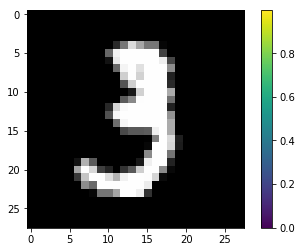

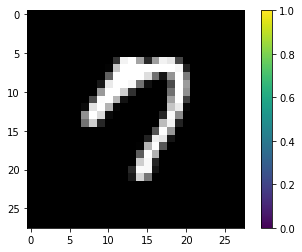

In [18]:
def show_img(img):
    plt.figure()
    plt.imshow(img)
    plt.colorbar()

print("MNIST SAMPLE: {}".format(mnist_y[10]))
show_img(mnist_X[10])
print("USPS SAMPLE: {}".format(usps_y[10]))
show_img(usps_X[10])

![F2]("Figure2.png")

### Dataset Details

 - For adaptation between MNIST and USPS, we follow the training protocol established in [21], __sampling 2000 images from MNIST and 1800 from USPS.__

### Model Details

 - our adversarial discriminator consists of 3 fully connected layers: two layers with 500 hidden units followed by the final discriminator output
 - Each of the 500-unit layers uses a ReLU activation function

In [40]:
def LeNetEncoder():
    model = tf.keras.Sequential()
    
    model.add(layers.Conv2D(20, (5, 5),
                        activation='relu',
                        input_shape=(28, 28, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Conv2D(50, (5, 5),
                        activation='relu',
                        input_shape=(28, 28, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.1))
    
    model.add(layers.Dense(500,
                           activation='relu'))
    
    return model

LNE = LeNetEncoder()
LNE.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 24, 24, 20)        1520      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 12, 12, 20)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 8, 8, 50)          25050     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 4, 4, 50)          0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 800)               0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 800)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 500)             

In [29]:
def LeNetClassifier():
    model = tf.keras.Sequential()
    model.add(layers.Dropout(0.1,
                             input_shape=(500,)))
    model.add(layers.Dense(10,
                           activation='relu'))
    
    return model

LNC = LeNetClassifier()
LNC.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_1 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                5010      
Total params: 5,010
Trainable params: 5,010
Non-trainable params: 0
_________________________________________________________________


In [41]:
usps_X[0].shape

(28, 28, 3)

In [46]:
embedding = LNE(usps_X[:3])
embedding.numpy()

array([[0.39568523, 0.        , 0.11663099, ..., 0.        , 0.19366807,
        0.1114129 ],
       [0.37635043, 0.        , 0.09811234, ..., 0.        , 0.12842494,
        0.02121469],
       [0.26739928, 0.        , 0.2933135 , ..., 0.        , 0.12806478,
        0.03212576]], dtype=float32)

In [47]:
pred = LNC(embedding)
pred.numpy()

array([[0.        , 0.04376975, 0.        , 0.01599182, 0.00599526,
        0.        , 0.        , 0.06911086, 0.19581142, 0.13797127],
       [0.        , 0.07259573, 0.        , 0.        , 0.        ,
        0.0332123 , 0.        , 0.0894923 , 0.1837567 , 0.07489282],
       [0.        , 0.09285565, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.08381765, 0.16857406, 0.16222906]],
      dtype=float32)